# Part1 Text Retrieval

## Import and Declare functions

In [76]:
import gzip # to install: pip install npc-gzip
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Kio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
# Define the function to calculate the NCD and return the indexes of the top k smallest distances
def compressed_search(query, text, k):
    x1 = query[0] if isinstance(query, tuple) else query
    Cx1 = len(gzip.compress(x1.encode()))
    distance_from_x1 = []
    # 2 cases will pass through this if statement: text is a dictionary or a tuple
    if isinstance(text, dict):
        # If text is a dictionary, iterate through its values
        for x2 in text.values():
            Cx2 = len(gzip.compress(x2.encode()))
            x1x2 = " ".join([x1, x2])
            Cx1x2 = len(gzip.compress(x1x2.encode()))
            ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
            distance_from_x1.append(ncd)
    elif isinstance(text, list):
        for (x2,_) in text:
            Cx2 = len(gzip.compress(x2.encode()))
            x1x2 = " ".join([x1, x2])
            Cx1x2 = len(gzip.compress(x1x2.encode()))
            ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
            distance_from_x1.append(ncd)
    return np.argsort(np.array(distance_from_x1))[:k] 

## Cranfield Dataset

### Load data and functions

In [61]:
# Load the data
with open('cranfield/cranfield.dat', 'r') as f:
    cranfield_lines = f.readlines()
    idx = 1
    cranfield_lines_idx = []
    for line in cranfield_lines:
        cranfield_lines_idx.append((line,idx))
        idx += 1

# Load the qrels
cranfield_qrels = {}
with open('cranfield/cranfield-qrels.txt', 'r') as f:
    for line in f:
        numbers = [int(n) for n in line.split()]
        key = numbers[0]
        if key not in cranfield_qrels:
            cranfield_qrels[key] = []
        cranfield_qrels[key].append(numbers[1:])

# Load the queries
with open('cranfield/cranfield-queries.txt', 'r') as f:
    cranfield_queries = f.readlines()
    idx = 1
    cranfield_queries_idx = []
    for line in cranfield_queries:
        cranfield_queries_idx.append((line,idx))
        idx += 1

# Load the stopwords
with open('stopwords.txt', 'r') as f:
    stopwords = f.readlines()
    stopwords = [word.strip() for word in stopwords]

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return filtered_tokens

def calc_ndcg(scored_result, cranfield_qrels, k):
    # Calculate the NDCG
    ndcg_result = []
    for key in scored_result:
        # Calculate the DCG
        dcg = 0
        for i in range(len(scored_result[key])):
            if i == 0:
                dcg += scored_result[key][i][1] # first element is not divided by log2
            else:
                dcg += scored_result[key][i][1] / np.log2(i+1) # i+1 because the index starts from 0
        # Calculate the IDCG        
        idcg = 0
        length = len(cranfield_qrels[key]) if len(cranfield_qrels[key]) < k else k # if the length of qrels is less than k, use the length of qrels
        sorted_cranfield_qrels = sorted(cranfield_qrels[key], key=lambda x: x[1], reverse=True) # sort the qrels by the score for IDCG
        for i in range(length): # calculate the IDCG
            if i == 0:
                idcg += sorted_cranfield_qrels[i][1]
            else:
                idcg += sorted_cranfield_qrels[i][1] / np.log2(i+1)
        ndcg_result.append(dcg/idcg) # calculate the NDCG and append it to the list
    return np.mean(np.array(ndcg_result))


### Test compression method

In [63]:
# Declare K
k = 10
# Execute the test and store the result
test_result = {}
for i in range(len(cranfield_queries_idx)):
    key = i+1
    if key not in test_result:
        test_result[key] = []
    # passing each query to the search function with the whole text and k
    test_result[key].append(compressed_search(cranfield_queries_idx[i], cranfield_lines_idx, k))

# Score the result by matching the result with the qrels
scored_result = {}
for key in test_result:
    if key not in scored_result:
        scored_result[key] = []
    # test_result[key][0] is the list of indexes of compressed_search result
    for i in range(len(test_result[key][0])): 
        for j in range(len(cranfield_qrels[key])):
            if test_result[key][0][i] == cranfield_qrels[key][j][0]:
                scored_result[key].append((i+1, cranfield_qrels[key][j][1]))
                break
        if len(scored_result[key]) < i+1:
            scored_result[key].append((i+1, 0))

In [64]:
cran_compress_ndcg = calc_ndcg(scored_result, cranfield_qrels, k)
print(f"The nDCG@{k} of the compressed search is ", format(cran_compress_ndcg, '.5f'))

The nDCG@10 of the compressed search is  0.02736


### test for multiple k values

In [67]:
k_values = np.arange(1,21)

In [68]:
cran_compress_ndcg_list = []
for k in k_values:
    # Execute the test and store the result
    test_result = {}
    for i in range(len(cranfield_queries_idx)):
        key = i+1
        if key not in test_result:
            test_result[key] = []
        # passing each query to the search function with the whole text and k
        test_result[key].append(compressed_search(cranfield_queries_idx[i], cranfield_lines_idx, k))

    # Score the result by matching the result with the qrels
    scored_result = {}
    for key in test_result:
        if key not in scored_result:
            scored_result[key] = []
        # test_result[key][0] is the list of indexes of compressed_search result
        for i in range(len(test_result[key][0])): 
            for j in range(len(cranfield_qrels[key])):
                if test_result[key][0][i] == cranfield_qrels[key][j][0]:
                    scored_result[key].append((i+1, cranfield_qrels[key][j][1]))
                    break
            if len(scored_result[key]) < i+1:
                scored_result[key].append((i+1, 0))
    cran_compress_ndcg_list.append(calc_ndcg(scored_result, cranfield_qrels, k))

### Test BM25

In [33]:
# Declare K
k = 10
# Tokenize the corpus and remove the stopwords
tokenized_corpus = [preprocess(line) for line, _ in cranfield_lines_idx]

# Train the model
bm25 = BM25Okapi(tokenized_corpus)

# Execute the test and store the result
test_result = {}
for i in range(len(cranfield_queries_idx)):
    key = i+1
    if key not in test_result:
        test_result[key] = []
    # tokenize the query and get the top k result
    tokenized_query = preprocess(cranfield_queries_idx[i][0])
    # append the result to the test_result
    test_result[key].append(np.argsort(bm25.get_scores(tokenized_query))[::-1][:k]) # [::-1] to sort in descending order

# Score the result by matching the result with the qrels
scored_result = {}
for key in test_result:
    if key not in scored_result:
        scored_result[key] = []
    # test_result[key][0] is the list of indexes of compressed_classification result
    for i in range(len(test_result[key][0])): 
        for j in range(len(cranfield_qrels[key])):
            if test_result[key][0][i] == cranfield_qrels[key][j][0]:
                scored_result[key].append((i+1, cranfield_qrels[key][j][1]))
                break
        if len(scored_result[key]) < i+1:
            scored_result[key].append((i+1, 0))

In [34]:
cran_bm25_ndcg = calc_ndcg(scored_result, cranfield_qrels, k)
print(f"The nDCG@{k} of the BM25 search is ", format(cran_bm25_ndcg, '.5f'))

The nDCG@10 of the BM25 search is  0.33176


### Test for multiple k values

In [71]:
tokenized_corpus = [preprocess(line) for line, _ in cranfield_lines_idx]
bm25 = BM25Okapi(tokenized_corpus)

cran_bm25_ndcg_list = []
for k in k_values:
    test_result = {}
    for i in range(len(cranfield_queries_idx)):
        key = i+1
        if key not in test_result:
            test_result[key] = []
        # tokenize the query and get the top k result
        tokenized_query = preprocess(cranfield_queries_idx[i][0])
        # append the result to the test_result
        test_result[key].append(np.argsort(bm25.get_scores(tokenized_query))[::-1][:k]) # [::-1] to sort in descending order

    scored_result = {}
    for key in test_result:
        if key not in scored_result:
            scored_result[key] = []
        # test_result[key][0] is the list of indexes of compressed_classification result
        for i in range(len(test_result[key][0])): 
            for j in range(len(cranfield_qrels[key])):
                if test_result[key][0][i] == cranfield_qrels[key][j][0]:
                    scored_result[key].append((i+1, cranfield_qrels[key][j][1]))
                    break
            if len(scored_result[key]) < i+1:
                scored_result[key].append((i+1, 0))
    cran_bm25_ndcg_list.append(calc_ndcg(scored_result, cranfield_qrels, k))

### Cranfield performance contrast compress vs BM25

Text(0.5, 1.0, 'nDCG@k of Compressed Search and BM25 Search')

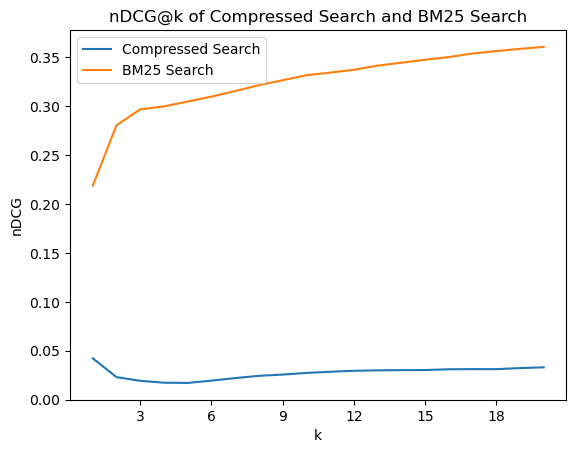

In [78]:
cran_result_list = [k_values, cran_compress_ndcg_list, cran_bm25_ndcg_list]
sns.lineplot(x=cran_result_list[0], y=cran_result_list[1], label="Compressed Search")
sns.lineplot(x=cran_result_list[0], y=cran_result_list[2], label="BM25 Search")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("k")
plt.ylabel("nDCG")
plt.title("nDCG@k of Compressed Search and BM25 Search")


## CISI Dataset

### Load data and functions

In [100]:
def read_documents ():
    f = open ("CISI/CISI.ALL")
    merged = " "
    # the string variable merged keeps the result of merging the field identifier with its content
    
    for a_line in f.readlines ():
        if a_line.startswith ("."):
            merged += "\n" + a_line.strip ()
        else:
            merged += " " + a_line.strip ()
    # updates the merged variable using a for-loop
    
    documents = {}
    
    content = ""
    doc_id = ""
    # each entry in the dictioanry contains key = doc_id and value = content
    
    for a_line in merged.split ("\n"):
        if a_line.startswith (".I"):
            doc_id = a_line.split (" ") [1].strip()
        elif a_line.startswith (".X"):
            documents[doc_id] = content
            content = ""
            doc_id = ""
        else:
            content += a_line.strip ()[3:] + " "
    f.close ()
    return documents


documents = read_documents ()

with open('CISI/CISI.QRY') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")
    
qry_set = {}
qry_id = ""
for l in lines:
    if l.startswith(".I"):
        qry_id = l.split(" ")[1].strip()
    elif l.startswith(".W"):
        qry_set[qry_id] = l.strip()[3:]
        qry_id = ""

rel_set = {}
with open('CISI/CISI.REL') as f:
    for l in f.readlines():
        qry_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0]
        doc_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1]
        if qry_id in rel_set:
            rel_set[qry_id].append(doc_id)
        else:
            rel_set[qry_id] = []
            rel_set[qry_id].append(doc_id)

def calc_map(scored_result):
    # Calculate the MAP
    map_result = []
    for key in scored_result.keys():
        temp = 0
        for i in range(len(scored_result[key])):
            if scored_result[key][i][1] == 1:
                temp += 1
        map_result.append(temp/(len(scored_result[key])))
    return np.mean(np.array(map_result))

def calc_mrr(scored_result):
    # Calculate the MRR
    mrr_result = []
    for key in scored_result.keys():
        temp = 0
        for i in range(len(scored_result[key])):
            if scored_result[key][i][1] == 1:
                temp = 1/(i+1)
        mrr_result.append(temp)
    return np.mean(np.array(mrr_result))

### Test compression method

In [101]:
# Declare K
k = 10
# Execute the test and store the result
test_result = {}
for key in qry_set.keys():
    if key not in test_result:
        test_result[key] = []
    # passing each query to the search function with the whole text and k
    test_result[key].append(compressed_search((qry_set[key],0), documents, k))

# Score the result by matching the result with the qrels
scored_result = {}
for key in test_result.keys():
    if key in rel_set.keys():
        if key not in scored_result.keys():
            scored_result[key] = []
        for test in test_result[key]:
            for i in test:
                # i+1 because the index starts from 0
                temp = str(i+1)
                if temp in rel_set[key]:
                    scored_result[key].append((i+1, 1))
                else:
                    scored_result[key].append((i+1, 0))

In [102]:
cisi_compress_map = calc_map(scored_result)
cisi_mean_reciprocal_rank = calc_mrr(scored_result)
print(f"The MAP of the compressed search is ", format(cisi_compress_map, '.5f'))
print(f"The MRR of the compressed search is ", format(cisi_mean_reciprocal_rank, '.5f'))

The MAP of the compressed search is  0.07763
The MRR of the compressed search is  0.13421


In [103]:
k_values = np.arange(1,21)

In [104]:
cisi_compress_map_list = []
cisi_compress_mrr_list = []
for k in k_values:
    test_result = {}
    for key in qry_set.keys():
        if key not in test_result:
            test_result[key] = []
        # passing each query to the search function with the whole text and k
        test_result[key].append(compressed_search((qry_set[key],0), documents, k))

    # Score the result by matching the result with the qrels
    scored_result = {}
    for key in test_result.keys():
        if key in rel_set.keys():
            if key not in scored_result.keys():
                scored_result[key] = []
            for test in test_result[key]:
                for i in test:
                    # i+1 because the index starts from 0
                    temp = str(i+1)
                    if temp in rel_set[key]:
                        scored_result[key].append((i+1, 1))
                    else:
                        scored_result[key].append((i+1, 0))
    cisi_compress_map_list.append(calc_map(scored_result))
    cisi_compress_mrr_list.append(calc_mrr(scored_result))

### BM25

In [105]:
# Declare K
k = 3

# Tokenize the corpus and remove the stopwords
tokenized_corpus = [preprocess(line) for line in documents.values()]

# Train the model
bm25 = BM25Okapi(tokenized_corpus)

# Execute the test and store the result
test_result = {}
for key in qry_set.keys():
    if key not in test_result:
        test_result[key] = []
    # tokenize the query and get the top k result
    tokenized_query = preprocess(qry_set[key])
    # append the result to the test_result
    test_result[key].append(np.argsort(bm25.get_scores(tokenized_query))[::-1][:k]) # [::-1] to sort in descending order


# Score the result by matching the result with the qrels
scored_result = {}
for key in test_result.keys():
    if key in rel_set.keys():
        if key not in scored_result.keys():
            scored_result[key] = []
        for test in test_result[key]:
            for i in test:
                temp = str(i+1)
                if temp in rel_set[key]:
                    scored_result[key].append((i+1, 1))
                else:
                    scored_result[key].append((i+1, 0))

In [106]:
cisi_bm25_map = calc_map(scored_result)
cisi_bm25_mean_reciprocal_rank = calc_mrr(scored_result)
print(f"The MAP of the BM25 search is ", format(cisi_bm25_map, '.5f'))
print(f"The MRR of the BM25 search is ", format(cisi_bm25_mean_reciprocal_rank, '.5f'))

The MAP of the BM25 search is  0.41228
The MRR of the BM25 search is  0.35307


In [107]:
# Tokenize the corpus and remove the stopwords
tokenized_corpus = [preprocess(line) for line in documents.values()]

# Train the model
bm25 = BM25Okapi(tokenized_corpus)

cisi_bm25_map_list = []
cisi_bm25_mrr_list = []

for k in k_values:
    test_result = {}
    for key in qry_set.keys():
        if key not in test_result:
            test_result[key] = []
        # tokenize the query and get the top k result
        tokenized_query = preprocess(qry_set[key])
        # append the result to the test_result
        test_result[key].append(np.argsort(bm25.get_scores(tokenized_query))[::-1][:k]) # [::-1] to sort in descending order


    # Score the result by matching the result with the qrels
    scored_result = {}
    for key in test_result.keys():
        if key in rel_set.keys():
            if key not in scored_result.keys():
                scored_result[key] = []
            for test in test_result[key]:
                for i in test:
                    temp = str(i+1)
                    if temp in rel_set[key]:
                        scored_result[key].append((i+1, 1))
                    else:
                        scored_result[key].append((i+1, 0))
    cisi_bm25_map_list.append(calc_map(scored_result))
    cisi_bm25_mrr_list.append(calc_mrr(scored_result))

### CISI performance contrast compress vs BM25

Text(0.5, 1.0, 'MAP@k of Compressed Search and BM25 Search')

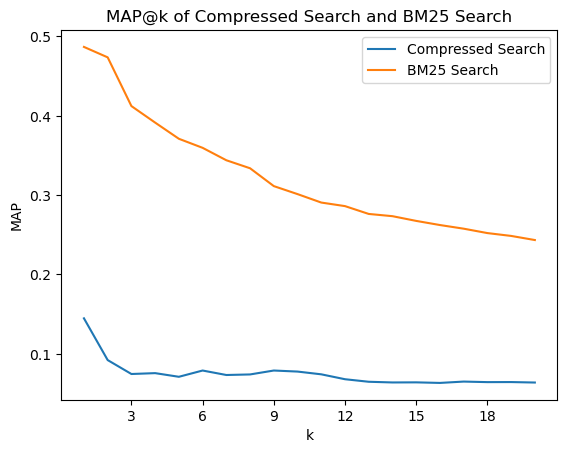

In [108]:
cisi_map_result_list = [k_values, cisi_compress_map_list, cisi_bm25_map_list]
sns.lineplot(x=cisi_map_result_list[0], y=cisi_map_result_list[1], label="Compressed Search")
sns.lineplot(x=cisi_map_result_list[0], y=cisi_map_result_list[2], label="BM25 Search")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("k")
plt.ylabel("MAP")
plt.title("MAP@k of Compressed Search and BM25 Search")

Text(0.5, 1.0, 'MRR@k of Compressed Search and BM25 Search')

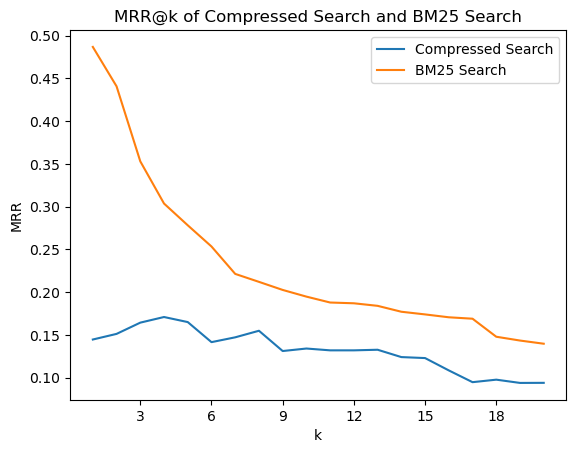

In [109]:
cisi_mrr_result_list = [k_values, cisi_compress_mrr_list, cisi_bm25_mrr_list]
sns.lineplot(x=cisi_mrr_result_list[0], y=cisi_mrr_result_list[1], label="Compressed Search")
sns.lineplot(x=cisi_mrr_result_list[0], y=cisi_mrr_result_list[2], label="BM25 Search")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("k")
plt.ylabel("MRR")
plt.title("MRR@k of Compressed Search and BM25 Search")